In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import os
import shutil
import random
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten
import matplotlib.pyplot as plt

Primero de todo, separaremos proporcinalmente el 15% que hemos decidido para el testing

In [2]:
img_width, img_height = 64, 64
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalizar valores de píxeles
    return img_array
data_dir = 'UA-LSE-Prueba'
destination_dir = 'UA-LSE-TESTING'
data = {}

# Itera sobre los archivos en el directorio de datos
for file_name in os.listdir(data_dir):
    if file_name.endswith('.png'):
        # Extrae información del nombre del archivo
        parts = file_name.split('_')
        letter = parts[0]
        side = parts[1]
        video_num = parts[2]
      
 
        key = (letter, side, video_num)

        # Carga y preprocesa la imagen
        file_path = os.path.join(data_dir, file_name)
        img_array = load_and_preprocess_image(file_path)

        # Almacena los datos de la imagen y la etiqueta en el diccionario
        if key not in data:
            data[key] = {'frames': [], 'label': f'{letter}_{side}'}
        data[key]['frames'].append((file_path, img_array))


# Agrupa las secuencias por clase (letter y side)
class_data = {}
for key, value in data.items():
    label = value['label']
    if label not in class_data:
        class_data[label] = []
    class_data[label].append((key, value['frames']))

# Selecciona el 15% de las secuencias completas de cada clase y muévelas a la carpeta destino
movement_records = []

for label, sequences in class_data.items():
    num_to_move = max(1, int(len(sequences) * 0.15))
    sequences_to_move = random.sample(sequences, num_to_move)

 

    for key, frames in sequences_to_move:
        for file_path, _ in frames:
            file_name = os.path.basename(file_path)
            dest_path = os.path.join(destination_dir, file_name)

            # Mueve el archivo a la carpeta de destino
            shutil.move(file_path, dest_path)

            # Registra el movimiento
            movement_records.append({'original_path': file_path, 'new_path': dest_path})

    # Elimina las secuencias movidas del diccionario original
    for key, _ in sequences_to_move:
        del data[key]

El procentaje de pruba, lo etiquetamos correctamente, para cada sequencia de imagenes, y entrenamos el modelo LSTM que hemos creado

c:\Users\garme\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 0.1404 - loss: 3.9661 - val_accuracy: 0.4540 - val_loss: 3.2441
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.6039 - loss: 2.7489 - val_accuracy: 0.7730 - val_loss: 2.0482
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.8988 - loss: 1.5914 - val_accuracy: 0.8742 - val_loss: 1.4279
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9785 - loss: 0.9520 - val_accuracy: 0.9110 - val_loss: 1.1019
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9883 - loss: 0.6512 - val_accuracy: 0.9049 - val_loss: 0.9142
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9989 - loss: 0.4659 - val_accuracy: 0.9049 - val_loss: 0.7819
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9981 - loss: 0.3159 - val_accuracy: 0.9202 - val_loss: 0.6997
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9996 - loss: 0.2312 - val_accuracy: 

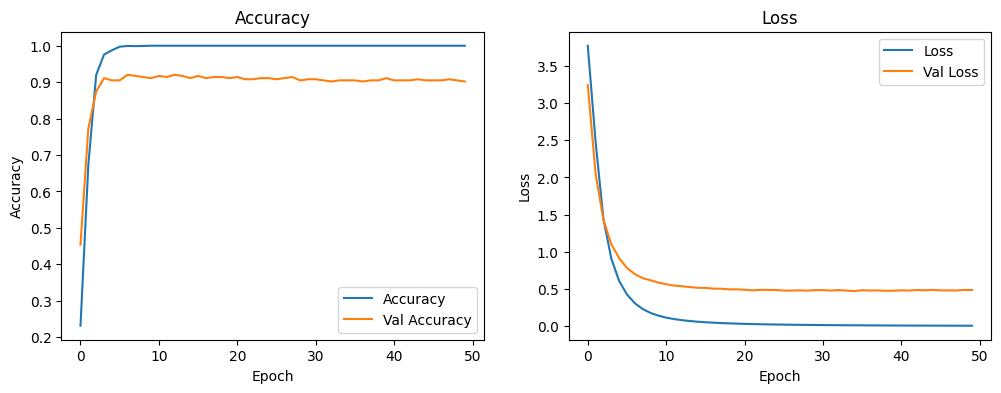

In [3]:
# Define la ruta al directorio de datos
data_dir = 'UA-LSE-Prueba'


# Crea un diccionario para almacenar los datos y etiquetas
data = {}

# Itera sobre los archivos en el directorio de datos
for file_name in os.listdir(data_dir):
    if file_name.endswith('.png'):
        # Extrae información del nombre del archivo
        parts = file_name.split('_')
        letter = parts[0]
        side = parts[1]
        video_num = parts[2]

        key = (letter, side, video_num)

        # Carga y preprocesa la imagen
        file_path = os.path.join(data_dir, file_name)
        img_array = load_and_preprocess_image(file_path)

        # Almacena los datos de la imagen y la etiqueta en el diccionario
        if key not in data:
            data[key] = {'frames': [], 'label': f'{letter}_{side}'}
        data[key]['frames'].append(img_array)

# Crea listas de secuencias y etiquetas
X = []
y = []
for key, value in data.items():
    X.append(value['frames'])
    y.append(value['label'])

# Convierte las etiquetas a codificación one-hot
num_classes = len(set(y))
label_encoder = LabelEncoder()
etiquetas_codificadas = label_encoder.fit_transform(y)

y = to_categorical(etiquetas_codificadas, num_classes=num_classes)

# Calcula la longitud máxima de las secuencias
max_len = max(len(seq) for seq in X)

# Rellena las secuencias con ceros al principio
X_padded = pad_sequences(X, maxlen=max_len, padding='pre', dtype='float32')

# Divide los datos en conjuntos de entrenamiento y validación (85%-15%)
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.15, random_state=42)

# Función para crear el modelo
def create_model():
    model = Sequential()
    model.add(TimeDistributed(Flatten(), input_shape=(max_len, img_width, img_height, 3)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Crear el modelo
model = create_model()

# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()



Hacemos el mismo paso pero para el conjunto de prueba y evalueamos el modelo.

In [6]:
# Define la ruta al directorio de test
test_dir = 'UA-LSE-TESTING'

# Crea un diccionario para almacenar los datos de test
test_data = {}

# Itera sobre los archivos en el directorio de test
for file_name in os.listdir(test_dir):
    if file_name.endswith('.png'):
        # Extrae información del nombre del archivo
        parts = file_name.split('_')
        letter = parts[0]
        side = parts[1]
        video_num = parts[2]

        key = (letter, side, video_num)

        # Carga y preprocesa la imagen
        file_path = os.path.join(test_dir, file_name)
        img_array = load_and_preprocess_image(file_path)

        # Almacena los datos de la imagen y la etiqueta en el diccionario
        if key not in test_data:
            test_data[key] = {'frames': [], 'label': f'{letter}_{side}'}
        test_data[key]['frames'].append(img_array)

# Crea listas de secuencias y etiquetas de test
X_test = []
y_test = []
for key, value in test_data.items():
    X_test.append(value['frames'])
    y_test.append(value['label'])

# Convierte las etiquetas de test a codificación one-hot
etiquetas_codificadas_test = label_encoder.transform(y_test)
y_test = to_categorical(etiquetas_codificadas_test, num_classes=num_classes)

# Calcula la longitud máxima de las secuencias de test
max_len_test = max(len(seq) for seq in X_test)

# Rellena las secuencias de test con ceros al principio
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre', dtype='float32')

# Evaluar el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')


Test loss: 0.3070, Test accuracy: 0.9310


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


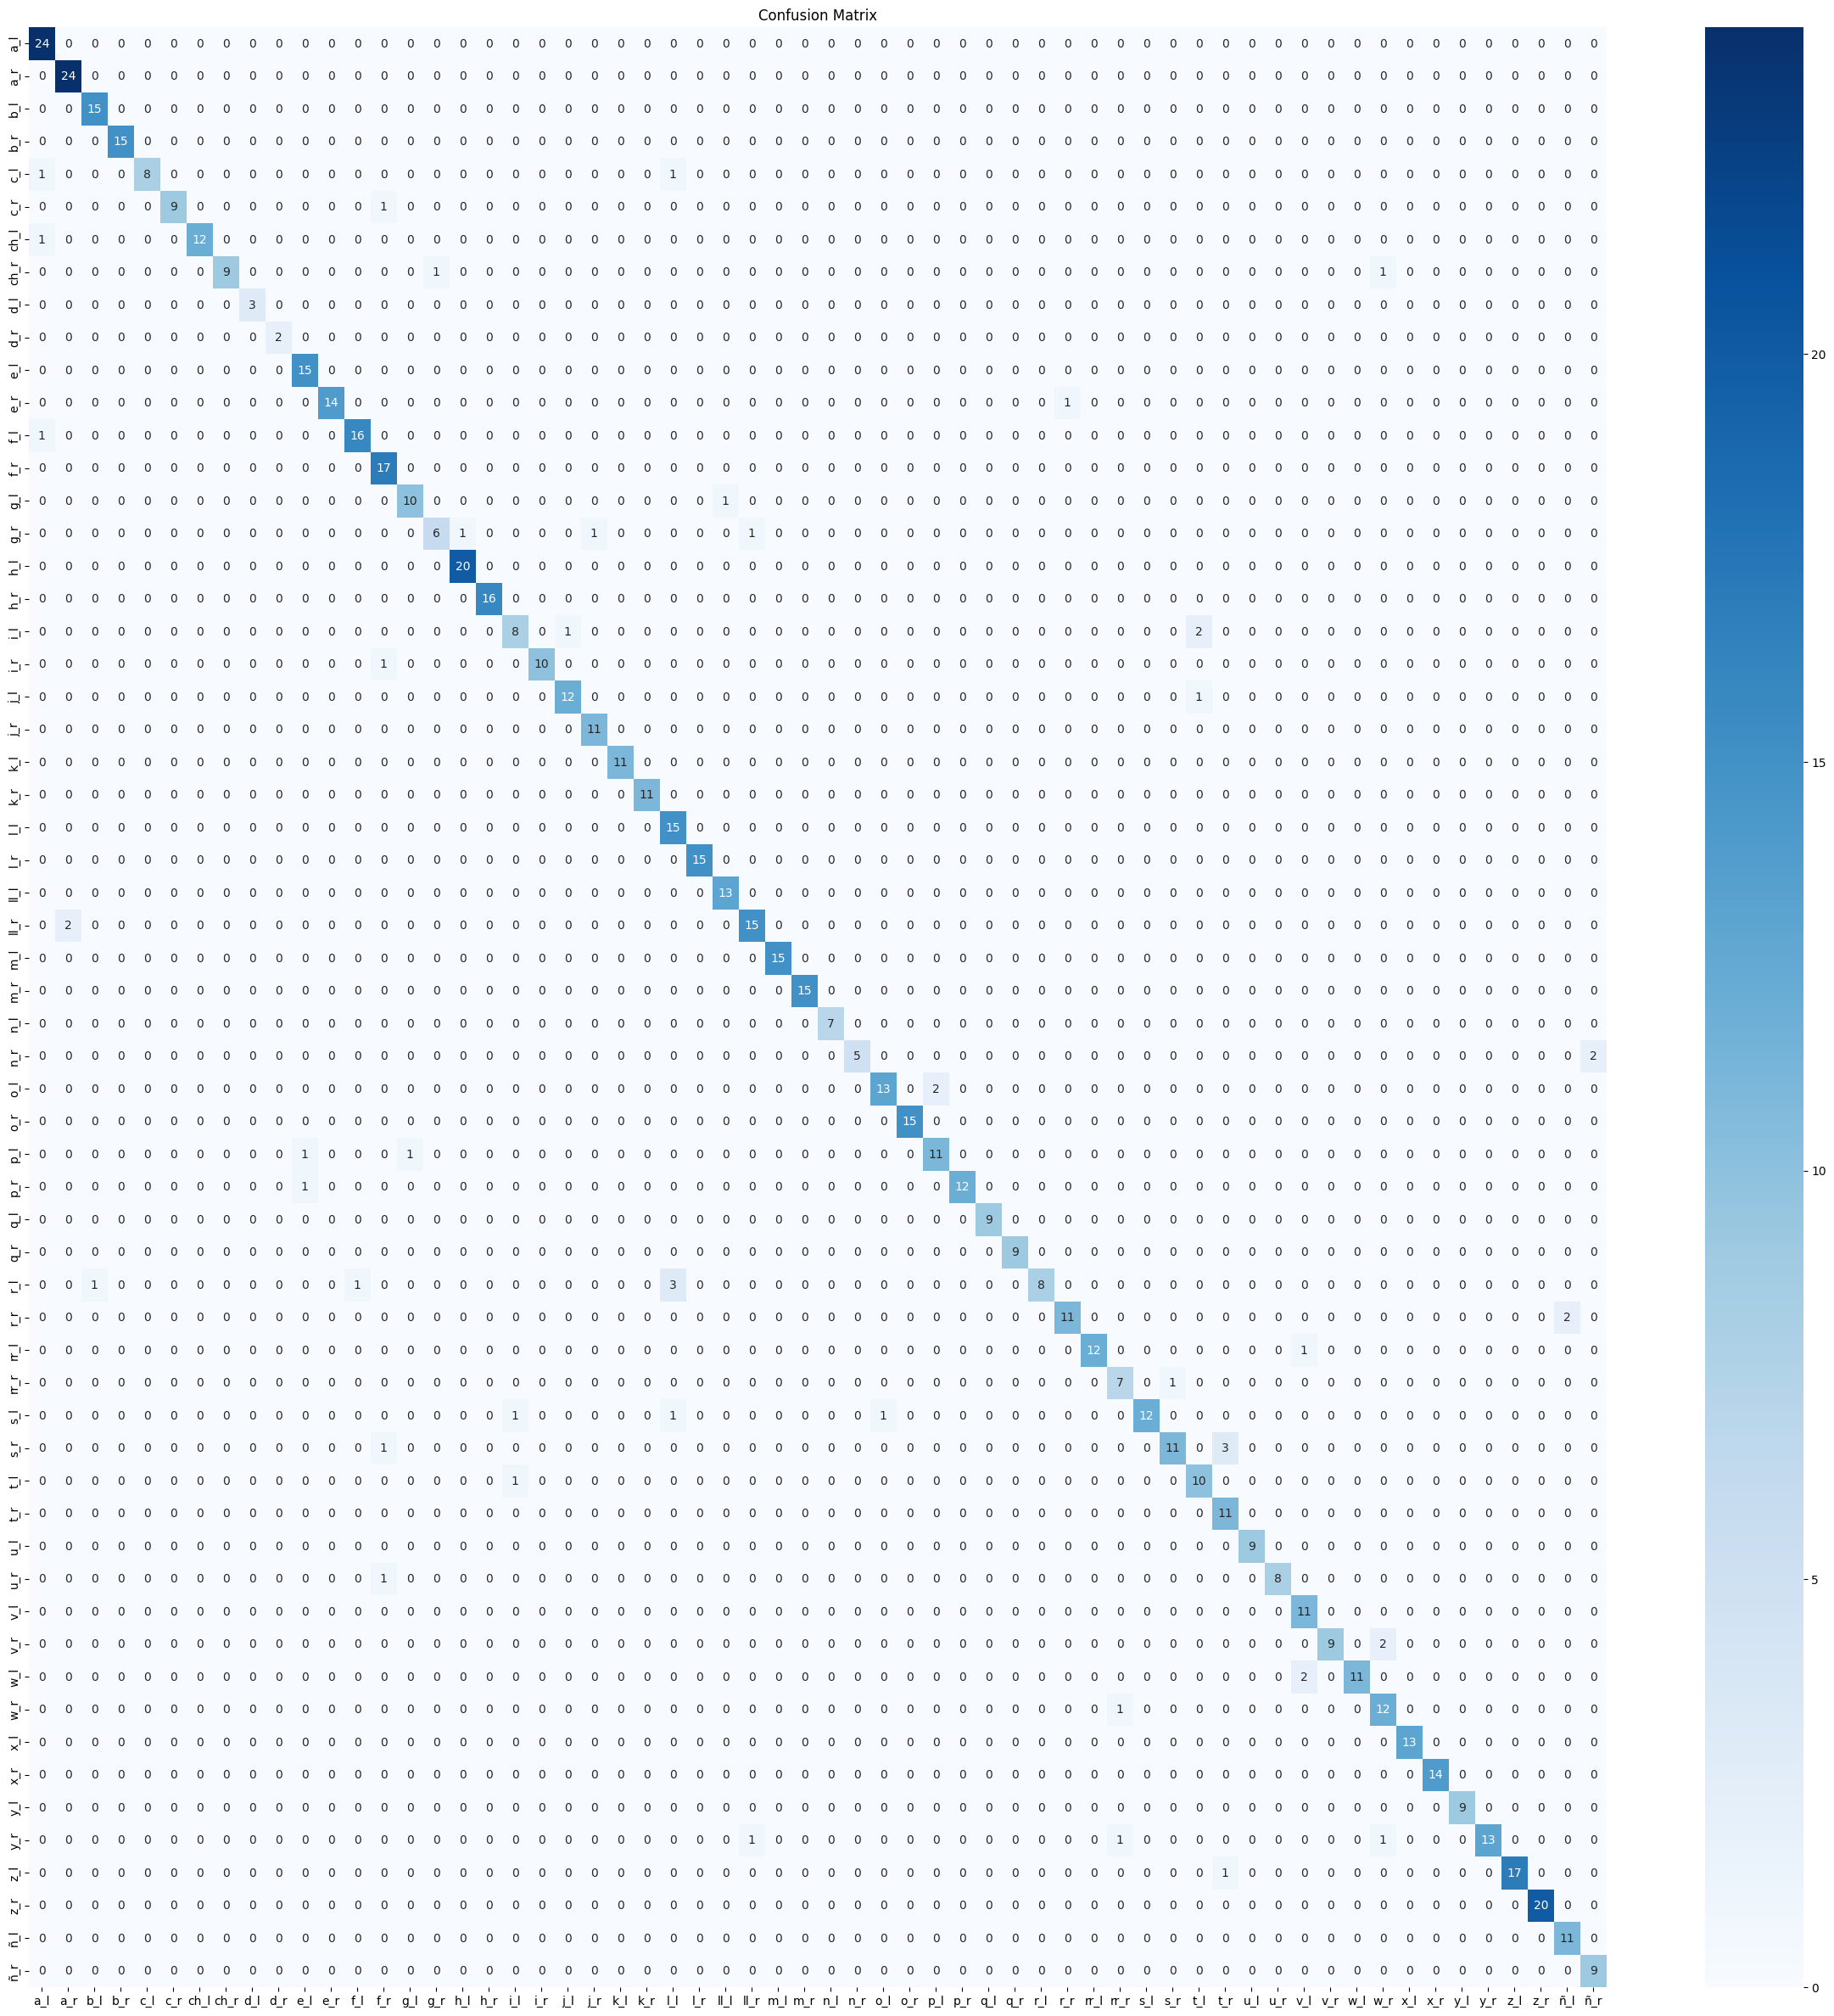

In [8]:
# Obtener las predicciones del modelo
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(np.argmax(y_test, axis =1), y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Visualizar la matriz de confusión
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.show()